In [6]:
import config
import helper_fxns as hf
import transforms as tr
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import time
%matplotlib inline

In [95]:
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(config)
C = config.Config()

In [153]:
gen_imgs("cyst", C.dims)

In [ ]:
gen_imgs("hcc", C.dims)
gen_imgs("hemangioma", C.dims)
gen_imgs("cholangio", C.dims)
gen_imgs("colorectal", C.dims)

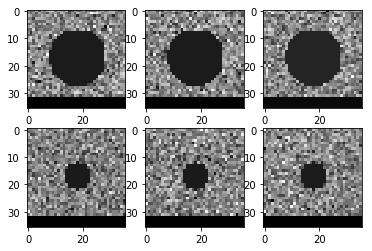

In [160]:
cls = "cyst"
img = np.load(C.artif_dir + cls + "\\artificial_7.npy")
hf.plot_section_auto_scan(img, 0.3)

In [123]:
def gen_imgs(cls, final_size):
    if cls == "cyst":
        imgs = gen_cysts(final_size)
    elif cls == "hcc":
        imgs = gen_hccs(final_size)
    elif cls == "hemangioma":
        imgs = gen_hems(final_size)
    elif cls == "cholangio":
        imgs = gen_cholangios(final_size)
    elif cls == "colorectal":
        imgs = gen_colorectals(final_size)
    
    if not os.path.exists(C.artif_dir + cls):
        os.makedirs(C.artif_dir + cls)
    for cnt, img in enumerate(imgs):
        np.save(C.artif_dir + cls + "\\artificial_" + str(cnt), img)

# Artificial Cysts

In [161]:
def gen_cysts(final_size):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Should be round and hypointense in all phases."""
    
    shades = [-0.8, -0.8, -0.8]
    return gen_round_lesions(shades, final_size)

In [152]:
def add_edge(img, edge_frac=0.3):
    final_size = img.shape
    
    edge_choice = random.randint(1, 4)
    if edge_choice == 1: #vertical
        edge_start = random.uniform(0, final_size[0]*edge_frac)
        edge_slope = random.uniform(-.1, .1)
        for y in range(final_size[1]):
            img[:math.floor(edge_start + edge_slope*y), y, :, :] = -1

    elif edge_choice == 2:
        edge_start = random.uniform(final_size[0]*(1-edge_frac), final_size[0])
        edge_slope = random.uniform(-.1, .1)
        for y in range(final_size[1]):
            img[math.ceil(edge_start + edge_slope*y):, y, :, :] = -1

    elif edge_choice == 3: #horizontal
        edge_start = random.uniform(0, final_size[1]*edge_frac)
        edge_slope = random.uniform(-.1, .1)
        for x in range(final_size[0]):
            img[x, :math.floor(edge_start + edge_slope*x), :, :] = -1

    else:
        edge_start = random.uniform(final_size[1]*(1-edge_frac), final_size[1])
        edge_slope = random.uniform(-.1, .1)
        for x in range(final_size[0]):
            img[x, math.ceil(edge_start + edge_slope*x):, :, :] = -1
    
    return img

In [162]:
def gen_round_lesions(shades, final_size, n=500):
    imgs = []
    long_size_frac = [0.7, 0.9]
    max_side_ratio = 1.5
    noise_std = 0.3
    shade_std = 0.1
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    
    for i in range(n):
        r = midx * sizes[i]
        shades_i = [shade+random.gauss(0, shade_std) for shade in shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                z = (r**2 - x**2 - (y/side_rat[i])**2)
                if z <= 0:
                    continue
                    
                z = math.floor(z**(.5)/z_ratio)
                
                if z > midz:
                    z = midz
                    
                img[x+midx, y+midy, midz-z:midy+z, :] = shades
        
        img = add_edge(img)
        
        imgs.append(img)
        
    return imgs

In [163]:
def gen_shrinking_lesions(shades, final_size, n=500):
    """Generate n images of hemangiomas with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases, but shrink over time."""
    
    imgs = []
    long_size_frac = [0.7, 0.9]
    max_side_ratio = 1.5
    noise_std = 0.3
    shade_std = 0.1
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    shrink_factor = [0.5, 0.8]
    
    for i in range(n):
        r = midx * sizes[i]
        rven = r * random.uniform(shrink_factor[0], shrink_factor[1])
        req = rven * random.uniform(shrink_factor[0], shrink_factor[1])
        shades_i = [shade+random.gauss(0, shade_std) for shade in shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                for ch, rad in enumerate([r, rven, req]):
                    z = (rad**2 - x**2 - (y/side_rat[i])**2)
                    if z <= 0:
                        continue

                    z = math.floor(z**(.5)/z_ratio)

                    if z > midz:
                        z = midz

                    img[x+midx, y+midy, midz-z:midy+z, ch] = shades[ch]
        
        img = add_edge(img)
                
        imgs.append(img)
        
    return imgs

# Artificial HCC

In [164]:
def gen_hccs(final_size):
    """Generate n images of hccs with dimensions of final_size plus channels defined by the config file.
    Should be round, enhancing in arterial, with washout in venous and delayed."""
    
    shades = [0.5, -0.2, -0.1]
    return gen_round_lesions(shades, final_size)

# Artificial Hemangioma

In [165]:
def gen_hems(final_size):
    """Generate n images of hccs with dimensions of final_size plus channels defined by the config file.
    Should be round, enhancing in arterial, with washout in venous and delayed."""
    
    shades = [-0.8, -0.8, -0.8]
    return gen_shrinking_lesions(shades, final_size)

# Artificial Cholangio

In [ ]:
def gen_cholangio(shades, final_size):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Mass-forming should have irregular, ragged rim enhancement with gradual centripetal enhancement."""
    
    shades = [-0.5, -0.5, -0.5]
    return gen_rimmed_lesions(shades, final_size)

# Artificial Colorectal

In [ ]:
def gen_colorectal(shades, final_size, n=50):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases (necrotic core) with an enhancing rim."""
    
    imgs = []
    long_size_frac = [0.7, 0.9]
    max_side_ratio = 1.5
    noise_std = 0.3
    shade_std = 0.1
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    
    for i in range(n):
        r = midx * sizes[i]
        shades_i = [shade+random.gauss(0, shade_std) for shade in shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                z = (r**2 - x**2 - (y/side_rat[i])**2)
                if z <= 0:
                    continue
                    
                z = math.floor(z**(.5)/z_ratio)
                
                if z > midz:
                    z = midz
                    
                img[x+midx, y+midy, midz-z:midy+z, :] = shades
                
        imgs.append(img)
        
    return imgs

# Artificial FNH